In [12]:
import pandas as pd
import numpy as np

In [2]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [4]:
symbol='EUR='

In [5]:
data = pd.DataFrame(raw[symbol])

In [6]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [7]:
lags = 5

In [ ]:
# Get lag vals for 1-5 lags (days) (get price for previous days)
# ex Price Day 6| 5 | 4 | 3 | 2 |1

In [8]:
cols = []
for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [9]:
cols

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

In [10]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,1.4513,1.4412,1.4318,1.4412,1.4368,1.4411
2010-01-12,1.4494,1.4513,1.4412,1.4318,1.4412,1.4368
2010-01-13,1.4510,1.4494,1.4513,1.4412,1.4318,1.4412
2010-01-14,1.4502,1.4510,1.4494,1.4513,1.4412,1.4318
2010-01-15,1.4382,1.4502,1.4510,1.4494,1.4513,1.4412


In [13]:
reg = np.linalg.lstsq(data[cols], data['price'], rcond=None)[0]

In [14]:
# These are the optimal regression params.  
# Illustrate the random walk hypothesis: stock prices follow random walk where todays price is best indicator of tomorrows price
# not the other values
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

In [19]:
# Calculate predicition values
data['prediction'] = np.dot(data[cols], reg)

<Axes: xlabel='Date'>

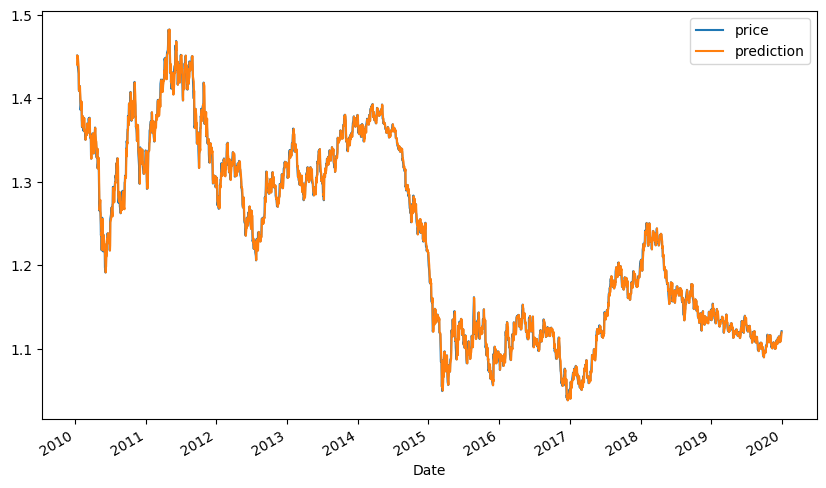

In [20]:
data[['price', 'prediction']].plot(figsize=(10,6))

<Axes: xlabel='Date'>

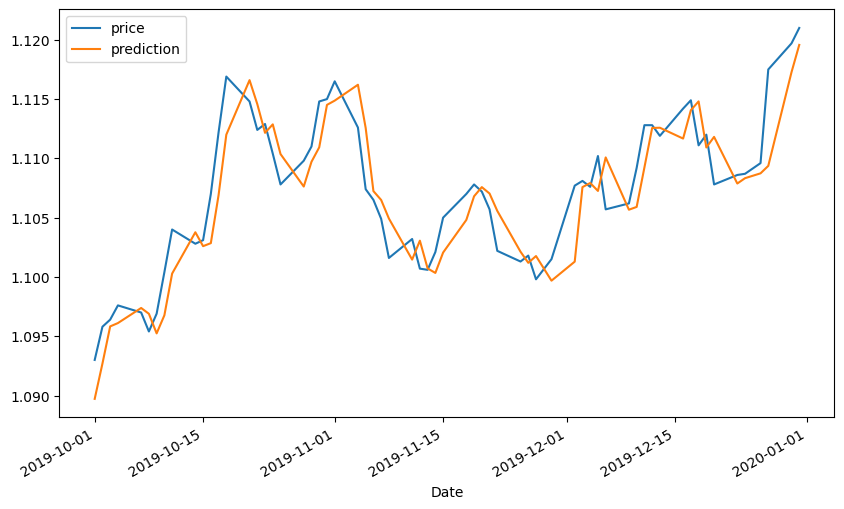

In [24]:
# Using linear regression, predicition for tomorrows price is todays price
data[['price', 'prediction']].loc['2019-10-1':].plot(figsize=(10, 6))

## Predicting Future Returns

In [25]:
# Calculate Regression based on LOG values
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [26]:
data.dropna(inplace=True)

In [27]:
cols = []
for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [28]:
reg = np.linalg.lstsq(data[cols], data['return'], rcond=None)[0]

In [29]:
reg

array([-0.015689  ,  0.00890227, -0.03634858,  0.01290924, -0.00636023])

In [30]:
data['prediction'] = np.dot(data[cols], reg)

<Axes: xlabel='Date'>

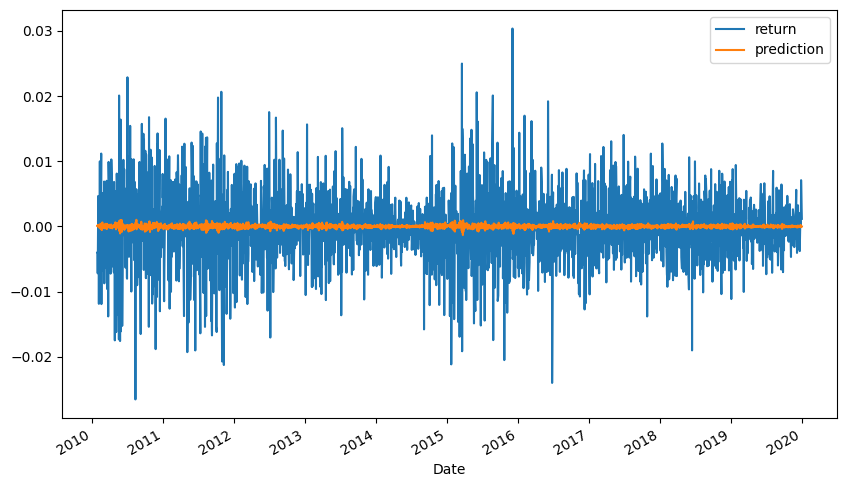

In [31]:
data[['return', 'prediction']].iloc[lags:].plot(figsize=(10,6))

In [ ]:
# when linear regression gets the direction of movement correct the product of market return and predicted return is positive
# otherwise negative

In [34]:
hits = np.sign(data['return'] * data['prediction']).value_counts()

In [35]:
hits

 1.0    1250
-1.0    1242
 0.0      13
Name: count, dtype: int64

In [37]:
hits.values[0] / sum(hits)

np.float64(0.499001996007984)

In [ ]:
# ~ 50 % accuracy

## Predicting Future Market Direction

In [38]:
# Instead of predicting absolute value of security
# Try to predict the direction of market movement, that should be more accurate

In [39]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']), rcond=None)[0]

In [40]:
reg

array([-5.11938725, -2.24077248, -5.13080606, -3.03753232, -2.14819119])

In [42]:
data['prediction'] = np.sign(np.dot(data[cols], reg))

In [43]:
data['prediction'].value_counts()

prediction
 1.0    1300
-1.0    1205
Name: count, dtype: int64

In [44]:
hits = np.sign(data['return'] * data['prediction']).value_counts()

In [45]:
hits

 1.0    1301
-1.0    1191
 0.0      13
Name: count, dtype: int64

In [46]:
hits.values[0] / sum(hits)

np.float64(0.5193612774451097)

In [47]:
# back test the above to use it to place longs or shorts

In [48]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,return
Date,,,,,,,,
2010-01-20,1.4101,-0.005858,-0.008309,-0.000551,0.001103,-0.001310,1.0,-0.013874
2010-01-21,1.4090,-0.013874,-0.005858,-0.008309,-0.000551,0.001103,1.0,-0.000780
2010-01-22,1.4137,-0.000780,-0.013874,-0.005858,-0.008309,-0.000551,1.0,0.003330
2010-01-25,1.4150,0.003330,-0.000780,-0.013874,-0.005858,-0.008309,1.0,0.000919
2010-01-26,1.4073,0.000919,0.003330,-0.000780,-0.013874,-0.005858,1.0,-0.005457


In [49]:
data['strategy'] = data['prediction'] * data['return']

In [51]:
data[['return', 'strategy']].sum().apply(np.exp)

return      0.784026
strategy    1.654154
dtype: float64

<Axes: xlabel='Date'>

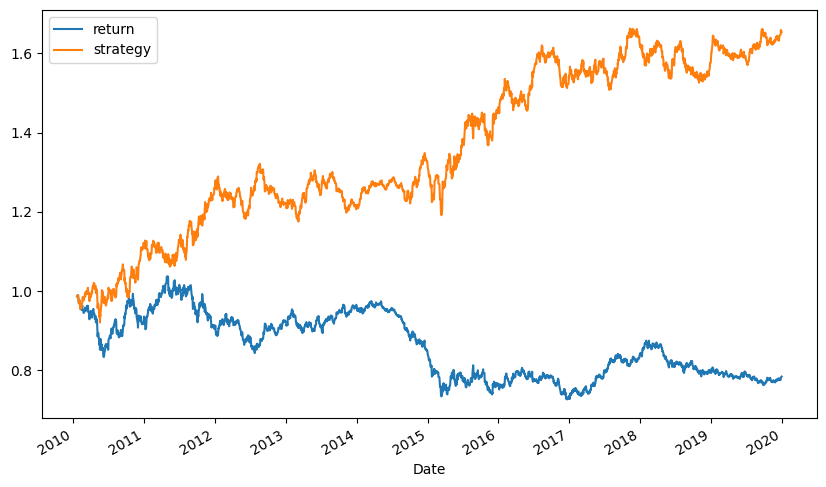

In [52]:
data[['return', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

In [53]:
# even if hit ratio is > 50% a stategy could get large movement days wrong and be a failure
# and vice versa